## Directory Structure in HPC

```
cmu-mosei-experiments/
├── .ipynb_checkpoints/
├── CMU-MultimodalSDK/
├── CMU-MultimodalSDK-Tutorials/
│   ├── .ipynb_checkpoints/
│   ├── constants/
│   └── data/
│       ├── CMU_MOSEI_COVAREP.csd
│       ├── CMU_MOSEI_Labels.csd
│       ├── CMU_MOSEI_OpenFace2.csd
│       ├── CMU_MOSEI_TimestampedPhones.csd
│       ├── CMU_MOSEI_TimestampedWords.csd
│       ├── CMU_MOSEI_TimestampedWordVectors.csd
│       └── CMU_MOSEI_VisualFacet42.csd
├── debug_mmsdk.py
├── README.md
├── text_LSTM.py
└── tutorial_interactive.ipynb
```

### Description of Data .csd Files:

- **data/**: Contains the CMU-MOSEI dataset files in `.csd` format
  - `CMU_MOSEI_COVAREP.csd`: Acoustic features
  - `CMU_MOSEI_Labels.csd`: Emotion labels and annotations
  - `CMU_MOSEI_OpenFace2.csd`: Visual facial features
  - `CMU_MOSEI_TimestampedPhones.csd`: Phone-level timestamps
  - `CMU_MOSEI_TimestampedWords.csd`: Word-level text features
  - `CMU_MOSEI_TimestampedWordVectors.csd`: Word vector embeddings
  - `CMU_MOSEI_VisualFacet42.csd`: 42-dimensional visual features

- **constants/**: Configuration and path constants
- **CMU-MultimodalSDK/**: Core SDK for multimodal data processing
- **CMU-MultimodalSDK-Tutorials/**: Tutorial notebooks and examples (Reference: https://github.com/Justin1904/CMU-MultimodalSDK-Tutorials)

## Steps for this analysis:
1. Connect to jupyter kernel of KCL HPC Create
2. And cd to the Tutorials directory, that's where the data is stored

In [2]:
%pwd

'/cephfs/volumes/hpc_data_usr/k24083007/2070c87e-fe07-4f03-a6c4-cae0de8ce617'

In [3]:
%cd cmu-mosei-experiments/CMU-MultimodalSDK-Tutorials/

/cephfs/volumes/hpc_data_usr/k24083007/2070c87e-fe07-4f03-a6c4-cae0de8ce617/cmu-mosei-experiments/CMU-MultimodalSDK-Tutorials


In [4]:
import mmsdk
import os
import re
import numpy as np
from mmsdk import mmdatasdk as md

import sys
import requests
from constants.paths import SDK_PATH, DATA_PATH

In [5]:
!nvidia-smi

Tue Jul  1 19:15:26 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:B1:00.0 Off |                    0 |
| N/A   27C    P0              47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [6]:
# Ensure SDK is in path
sys.path.append(SDK_PATH)

# Make sure DATA_PATH exists
if not os.path.exists(DATA_PATH):
    print(f"Error: DATA_PATH does not exist: {DATA_PATH}")
    print("Please modify DATA_PATH to point to your .csd files directory")
    # os.makedirs(DATA_PATH, exist_ok=True)
else:
    data_files = os.listdir(DATA_PATH)
    print("Available data files:")
    print('\n'.join(data_files))

Available data files:
CMU_MOSEI_COVAREP.csd
CMU_MOSEI_TimestampedWords.csd
CMU_MOSEI_OpenFace2.csd
CMU_MOSEI_VisualFacet42.csd
CMU_MOSEI_TimestampedWordVectors.csd
CMU_MOSEI_TimestampedPhones.csd
CMU_MOSEI_Labels.csd


### Viewing the features
Loading the multimodal dataset

In [8]:
text_field = 'CMU_MOSEI_TimestampedWordVectors'
visual_field = 'CMU_MOSEI_VisualFacet42'
acoustic_field = 'CMU_MOSEI_COVAREP'

# Define the features to load
features = [
    text_field, 
    visual_field, 
    acoustic_field
]

recipe = {feat: os.path.join(DATA_PATH, feat) + '.csd' for feat in features}

# Load the dataset
try:
    dataset = md.mmdataset(recipe)
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Available files:", data_files)

[2025-07-01 18:19:14.848] | Success | Computational sequence read from file ./data/CMU_MOSEI_TimestampedWordVectors.csd ...
[2025-07-01 18:19:51.934] | Status  | Checking the integrity of the <glove_vectors> computational sequence ...
[2025-07-01 18:19:51.934] | Status  | Checking the format of the data in <glove_vectors> computational sequence ...


[2025-07-01 18:19:52.891] | Success | <glove_vectors> computational sequence data in correct format.
[2025-07-01 18:19:52.891] | Status  | Checking the format of the metadata in <glove_vectors> computational sequence ...
[2025-07-01 18:19:52.891] | Warning | <glove_vectors> computational sequence does not have all the required metadata ... continuing 
[2025-07-01 18:19:52.892] | Success | Computational sequence read from file ./data/CMU_MOSEI_VisualFacet42.csd ...
[2025-07-01 18:19:52.962] | Status  | Checking the integrity of the <FACET 4.2> computational sequence ...
[2025-07-01 18:19:52.962] | Status  | Checking the format of the data in <FACET 4.2> computational sequence ...


[2025-07-01 18:19:53.847] | Success | <FACET 4.2> computational sequence data in correct format.
[2025-07-01 18:19:53.847] | Status  | Checking the format of the metadata in <FACET 4.2> computational sequence ...
[2025-07-01 18:19:53.847] | Warning | <FACET 4.2> computational sequence does not have all the required metadata ... continuing 
[2025-07-01 18:19:53.847] | Success | Computational sequence read from file ./data/CMU_MOSEI_COVAREP.csd ...
[2025-07-01 18:20:18.470] | Status  | Checking the integrity of the <COVAREP> computational sequence ...
[2025-07-01 18:20:18.470] | Status  | Checking the format of the data in <COVAREP> computational sequence ...


[2025-07-01 18:20:49.290] | Success | <COVAREP> computational sequence data in correct format.
[2025-07-01 18:20:49.290] | Status  | Checking the format of the metadata in <COVAREP> computational sequence ...
[2025-07-01 18:20:49.290] | Warning | <COVAREP> computational sequence does not have all the required metadata ... continuing 
[2025-07-01 18:20:49.290] | Success | Dataset initialized successfully ... 
Dataset loaded successfully!


In [ ]:
# Explore the dataset structure
print("Dataset keys:", list(dataset.keys()))
print("=" * 80)

# Get video IDs from one modality
video_ids = list(dataset[visual_field].keys())
print(f"Number of videos: {len(video_ids)}")
print("First 10 video IDs:", video_ids[:10])
print("=" * 80)

# Examine a specific video
some_id = video_ids[15] if len(video_ids) > 15 else video_ids[0]
print(f"Examining video: {some_id}")
print("Available data for this video:", list(dataset[visual_field][some_id].keys()))
print("=" * 80)

# Check shapes of different modalities for this video
print("Visual features shape:", dataset[visual_field][some_id]['features'].shape) # (time_steps or intervals, feature_dim)
print("Visual intervals shape:", dataset[visual_field][some_id]['intervals'].shape) # (time_steps or intervals, 2) 2 because start and end times
print("Text features shape:", dataset[text_field][some_id]['features'].shape)
print("Acoustic features shape:", dataset[acoustic_field][some_id]['features'].shape)

Dataset keys: ['CMU_MOSEI_TimestampedWords', 'CMU_MOSEI_VisualFacet42', 'CMU_MOSEI_COVAREP']
Number of videos: 3837
First 10 video IDs: ['--qXJuDtHPw', '-3g5yACwYnA', '-3nNcZdcdvU', '-571d8cVauQ', '-6rXp3zJ3kc', '-9YyBTjo1zo', '-9y-fZ3swSY', '-AUZQgSxyPQ', '-Alixo7euuU', '-Eqdz5y4pEY']
Examining video: -IqSFQePnpU
Available data for this video: ['features', 'intervals']
Visual features shape: (3658, 35)
Visual intervals shape: (3658, 2)
Text features shape: (321, 1)
Acoustic features shape: (12209, 74)


Different modalities have different number of time steps

In [ ]:
# Align the modalities (following the tutorial approach)
def avg(intervals: np.array, features: np.array) -> np.array:
    """Simple averaging function that does not depend on intervals"""
    try:
        return np.average(features, axis=0)
    except:
        return features

# Align to words with averaging
print("Aligning modalities to text...")
dataset.align(text_field, collapse_functions=[avg])
print("Alignment completed!")

Aligning modalities to text...
[2025-06-30 09:18:18.174] | Status  | Unify was called ...
[2025-06-30 09:18:18.177] | Warning | PEBwwe0PLZ8 entry is not shared among all sequences, removing it ...
[2025-06-30 09:18:18.178] | Success | Unify completed ...
[2025-06-30 09:18:18.178] | Status  | Pre-alignment based on <CMU_MOSEI_TimestampedWords> computational sequence started ...
[2025-06-30 09:20:17.774] | Status  | Pre-alignment done for <CMU_MOSEI_COVAREP> ...
[2025-06-30 09:20:33.170] | Status  | Pre-alignment done for <CMU_MOSEI_VisualFacet42> ...
[2025-06-30 09:20:33.642] | Status  | Alignment starting ...


[2025-06-30 09:56:28.641] | Success | Alignment to <CMU_MOSEI_TimestampedWords> complete.
[2025-06-30 09:56:28.641] | Status  | Replacing dataset content with aligned computational sequences
[2025-06-30 09:56:28.730] | Success | Initialized empty <CMU_MOSEI_TimestampedWords> computational sequence.
[2025-06-30 09:56:28.736] | Status  | Checking the format of the data in <CMU_MOSEI_TimestampedWords> computational sequence ...


[2025-06-30 09:56:30.746] | Success | <CMU_MOSEI_TimestampedWords> computational sequence data in correct format.
[2025-06-30 09:56:30.800] | Status  | Checking the format of the metadata in <CMU_MOSEI_TimestampedWords> computational sequence ...
[2025-06-30 09:56:30.803] | Warning | <CMU_MOSEI_TimestampedWords> computational sequence does not have all the required metadata ... continuing 
[2025-06-30 09:56:30.806] | Success | Initialized empty <CMU_MOSEI_VisualFacet42> computational sequence.
[2025-06-30 09:56:30.941] | Status  | Checking the format of the data in <CMU_MOSEI_VisualFacet42> computational sequence ...


[2025-06-30 09:56:32.492] | Success | <CMU_MOSEI_VisualFacet42> computational sequence data in correct format.
[2025-06-30 09:56:32.492] | Status  | Checking the format of the metadata in <CMU_MOSEI_VisualFacet42> computational sequence ...
[2025-06-30 09:56:32.492] | Warning | <CMU_MOSEI_VisualFacet42> computational sequence does not have all the required metadata ... continuing 
[2025-06-30 09:56:32.492] | Success | Initialized empty <CMU_MOSEI_COVAREP> computational sequence.
[2025-06-30 09:56:32.492] | Status  | Checking the format of the data in <CMU_MOSEI_COVAREP> computational sequence ...


[2025-06-30 09:56:33.845] | Success | <CMU_MOSEI_COVAREP> computational sequence data in correct format.
[2025-06-30 09:56:33.845] | Status  | Checking the format of the metadata in <CMU_MOSEI_COVAREP> computational sequence ...
[2025-06-30 09:56:33.845] | Warning | <CMU_MOSEI_COVAREP> computational sequence does not have all the required metadata ... continuing 
Alignment completed!


In [ ]:
# Add labels and align to them
label_field = 'CMU_MOSEI_Labels'

# Add labels to the dataset
label_recipe = {label_field: os.path.join(DATA_PATH, label_field + '.csd')}
dataset.add_computational_sequences(label_recipe, destination=None)

# Align to labels to get labeled segments
dataset.align(label_field)

# Check the new keys format
new_keys = list(dataset[text_field].keys())
print(f"After alignment, keys changed to format: {new_keys[55]}")
print(f"Total number of segments: {len(new_keys)}")

[2025-06-30 12:02:05.724] | Warning | Dataset already contains <CMU_MOSEI_Labels> computational sequence ...
[2025-06-30 12:02:05.725] | Success | Computational sequence read from file ./data/CMU_MOSEI_Labels.csd ...
[2025-06-30 12:02:05.799] | Status  | Checking the integrity of the <All Labels> computational sequence ...
[2025-06-30 12:02:05.800] | Status  | Checking the format of the data in <All Labels> computational sequence ...


[2025-06-30 12:02:06.613] | Success | <All Labels> computational sequence data in correct format.
[2025-06-30 12:02:06.613] | Status  | Checking the format of the metadata in <All Labels> computational sequence ...
[2025-06-30 12:02:06.613] | Warning | <All Labels> computational sequence does not have all the required metadata ... continuing 
[2025-06-30 12:02:06.698] | Status  | Unify was called ...
[2025-06-30 12:02:06.863] | Warning | HuIKyKkEL0Q entry is not shared among all sequences, removing it ...
[2025-06-30 12:02:06.872] | Warning | PEBwwe0PLZ8 entry is not shared among all sequences, removing it ...
[2025-06-30 12:02:06.880] | Success | Unify completed ...
[2025-06-30 12:02:06.881] | Status  | Pre-alignment based on <CMU_MOSEI_Labels> computational sequence started ...
[2025-06-30 12:02:07.120] | Status  | Pre-alignment done for <CMU_MOSEI_TimestampedWords> ...
[2025-06-30 12:02:07.538] | Status  | Pre-alignment done for <CMU_MOSEI_COVAREP> ...
[2025-06-30 12:02:07.892] | St

Overall Progress:  51%|█████     | 1664/3291 [00:18<00:13, 116.47 Computational Sequence Entries/s]
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)


[2025-06-30 12:02:42.057] | Success | Alignment to <CMU_MOSEI_Labels> complete.
[2025-06-30 12:02:42.057] | Status  | Replacing dataset content with aligned computational sequences
[2025-06-30 12:02:42.160] | Success | Initialized empty <CMU_MOSEI_TimestampedWords> computational sequence.
[2025-06-30 12:02:42.196] | Status  | Checking the format of the data in <CMU_MOSEI_TimestampedWords> computational sequence ...


[2025-06-30 12:02:42.259] | Success | <CMU_MOSEI_TimestampedWords> computational sequence data in correct format.
[2025-06-30 12:02:42.279] | Status  | Checking the format of the metadata in <CMU_MOSEI_TimestampedWords> computational sequence ...
[2025-06-30 12:02:42.307] | Warning | <CMU_MOSEI_TimestampedWords> computational sequence does not have all the required metadata ... continuing 
[2025-06-30 12:02:42.326] | Success | Initialized empty <CMU_MOSEI_VisualFacet42> computational sequence.
[2025-06-30 12:02:42.344] | Status  | Checking the format of the data in <CMU_MOSEI_VisualFacet42> computational sequence ...


[2025-06-30 12:02:42.382] | Success | <CMU_MOSEI_VisualFacet42> computational sequence data in correct format.
[2025-06-30 12:02:42.382] | Status  | Checking the format of the metadata in <CMU_MOSEI_VisualFacet42> computational sequence ...
[2025-06-30 12:02:42.423] | Warning | <CMU_MOSEI_VisualFacet42> computational sequence does not have all the required metadata ... continuing 
[2025-06-30 12:02:42.440] | Success | Initialized empty <CMU_MOSEI_COVAREP> computational sequence.
[2025-06-30 12:02:42.462] | Status  | Checking the format of the data in <CMU_MOSEI_COVAREP> computational sequence ...


[2025-06-30 12:02:42.528] | Success | <CMU_MOSEI_COVAREP> computational sequence data in correct format.
[2025-06-30 12:02:42.552] | Status  | Checking the format of the metadata in <CMU_MOSEI_COVAREP> computational sequence ...
[2025-06-30 12:02:42.556] | Warning | <CMU_MOSEI_COVAREP> computational sequence does not have all the required metadata ... continuing 
[2025-06-30 12:02:42.572] | Success | Initialized empty <CMU_MOSEI_Labels> computational sequence.
[2025-06-30 12:02:42.582] | Status  | Checking the format of the data in <CMU_MOSEI_Labels> computational sequence ...


[2025-06-30 12:02:42.623] | Success | <CMU_MOSEI_Labels> computational sequence data in correct format.
[2025-06-30 12:02:42.623] | Status  | Checking the format of the metadata in <CMU_MOSEI_Labels> computational sequence ...
[2025-06-30 12:02:42.623] | Warning | <CMU_MOSEI_Labels> computational sequence does not have all the required metadata ... continuing 
After alignment, keys changed to format: -HwX2H8Z4hY[4]
Total number of segments: 23247


In [ ]:
# Analyze the data statistics
print("----------------------------------- DATA ANALYSIS -----------------------------------")

# Count segments per modality
text_segments = len(list(dataset[text_field].keys()))
visual_segments = len(list(dataset[visual_field].keys()))
acoustic_segments = len(list(dataset[acoustic_field].keys()))
label_segments = len(list(dataset[label_field].keys()))

print(f"Text segments: {text_segments}")
print(f"Visual segments: {visual_segments}")
print(f"Acoustic segments: {acoustic_segments}")
print(f"Label segments: {label_segments}")

# Sample a few segments to check data
sample_segments = list(dataset[label_field].keys())[:5]
for segment in sample_segments:
    try:
        text_shape = dataset[text_field][segment]['features'].shape
        visual_shape = dataset[visual_field][segment]['features'].shape
        acoustic_shape = dataset[acoustic_field][segment]['features'].shape
        label_shape = dataset[label_field][segment]['features'].shape
        
        print(f"\nSegment: {segment}")
        print(f"  Text: {text_shape}, Visual: {visual_shape}, Acoustic: {acoustic_shape}, Label: {label_shape}")
        print(f"  Label value: {dataset[label_field][segment]['features']}")
    except KeyError as e:
        print(f"Missing data for segment {segment}: {e}")

----------------------------------- DATA ANALYSIS -----------------------------------
Text segments: 23248
Visual segments: 23240
Acoustic segments: 23248
Label segments: 23248

Segment: --qXJuDtHPw[0]
  Text: (22, 1), Visual: (22, 35), Acoustic: (22, 74), Label: (1, 7)
  Label value: [[1.        0.6666667 0.        0.        0.        0.        0.       ]]

Segment: -3g5yACwYnA[0]
  Text: (55, 1), Visual: (55, 35), Acoustic: (55, 74), Label: (1, 7)
  Label value: [[1.        0.6666667 0.6666667 0.        0.        0.        0.6666667]]

Segment: -3g5yACwYnA[1]
  Text: (22, 1), Visual: (22, 35), Acoustic: (22, 74), Label: (1, 7)
  Label value: [[0.6666667 0.        0.        0.        0.        0.        0.       ]]

Segment: -3g5yACwYnA[2]
  Text: (23, 1), Visual: (23, 35), Acoustic: (23, 74), Label: (1, 7)
  Label value: [[0.         0.6666667  0.6666667  0.         0.         0.
  0.33333334]]

Segment: -3g5yACwYnA[3]
  Text: (42, 1), Visual: (42, 35), Acoustic: (42, 74), Label: (1,

## Downloading the alternate glove vectors (ref: sdk) 
(Not able to download, host server is down)

In [ ]:
# Define direct URLs to the MOSEI dataset
mosei_urls = {
    "CMU_MOSEI_GloveVectorswithSP.csd": "http://immortal.multicomp.cs.cmu.edu/CMU-MOSEI/language/CMU_MOSEI_TimestampedGloveVectors_with_SP.csd"
}

# Download files directly using requests
for filename, url in mosei_urls.items():
    file_path = os.path.join(DATA_PATH, filename)
    if os.path.exists(file_path):
        print(f"File {filename} already exists, skipping download")
        continue
        
    print(f"Downloading {url} to {file_path}")
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Successfully downloaded {filename}")
        else:
            print(f"Failed to download {filename}: HTTP {response.status_code}")
    except Exception as e:
        print(f"Error downloading {filename}: {e}")

print("\nDownloaded files in DATA_PATH:")
for file in os.listdir(DATA_PATH):
    print(f"- {file}")

print("\nNow you can continue using the downloaded files.")

Error downloading CMU_MOSEI_GloveVectorswithSP.csd: HTTPConnectionPool(host='immortal.multicomp.cs.cmu.edu', port=80): Max retries exceeded with url: /CMU-MOSEI/language/CMU_MOSEI_TimestampedGloveVectors_with_SP.csd (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x76f2cb393310>, 'Connection to immortal.multicomp.cs.cmu.edu timed out. (connect timeout=None)'))

Downloaded files in DATA_PATH:
- CMU_MOSEI_COVAREP.csd
- CMU_MOSEI_TimestampedWords.csd
- CMU_MOSEI_OpenFace2.csd
- CMU_MOSEI_VisualFacet42.csd
- CMU_MOSEI_TimestampedWordVectors.csd
- CMU_MOSEI_TimestampedPhones.csd
- CMU_MOSEI_Labels.csd

Now you can continue using the downloaded files.


# Data Viz

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

plt.style.use('default')
sns.set_palette("husl")

In [ ]:
dataset

In [ ]:
# Collect all labels
all_labels = []
segment_ids = []

for segment_id in list(dataset[label_field].keys()):
    try:
        features = dataset[label_field][segment_id]['features']
        
        # Handle different label formats
        if len(features.shape) == 1:
            label_values = features
        else:
            # Average over time dimension if present
            label_values = features.mean(axis=0)
        
        all_labels.append(label_values)
        segment_ids.append(segment_id)
        
    except Exception as e:
        print(f"Error processing segment {segment_id}: {e}")
        continue

all_labels_data = np.array(all_labels)
print(f"Collected {len(all_labels)} segments")
print(f"Label dimensions: {all_labels_data.shape[1] if len(all_labels_data.shape) > 1 else 1}")

Collected 23248 segments
Label dimensions: 7


In [ ]:
# Get some emotion stats
# 
# emotion_names = ['Sentiment', 'Happy', 'Sad', 'Anger', 'Surprise', 'Disgust', 'Fear']
n_emotions = min(len(emotion_names), all_labels_data.shape[1]) # Because some datasets may not have all emotions


stats_dict = {}

for i in range(min(len(emotion_names), all_labels_data.shape[1])):
    emotion = emotion_names[i]
    values = all_labels_data[:, i]
    
    stats = {
        'mean': values.mean(),
        'std': values.std(),
        'min': values.min(),
        'max': values.max(),
        'median': np.median(values)
    }
    
    stats_dict[emotion] = stats
    
    print(f"\n{emotion}:")
    print(f"  Range: [{stats['min']:.3f}, {stats['max']:.3f}]")
    print(f"  Mean ± Std: {stats['mean']:.3f} ± {stats['std']:.3f}")
    print(f"  Median: {stats['median']:.3f}")
    
    # Special analysis for sentiment
    if emotion == 'Sentiment':
        positive = (values > 0).sum()
        negative = (values < 0).sum()
        neutral = (np.abs(values) < 0.1).sum()
        print(f"  Distribution: Positive={positive}, Negative={negative}, Neutral={neutral}")
    else:
        # For emotions, check presence/absence
        present = (values > 0.1).sum()
        absent = (values <= 0.1).sum()
        print(f"  Presence: Present={present} ({present/len(values)*100:.1f}%), Absent={absent}")
    


Happy:
  Range: [-3.000, 3.000]
  Mean ± Std: 0.152 ± 1.112
  Median: 0.000
  Presence: Present=11471 (49.3%), Absent=11777

Sad:
  Range: [0.000, 3.000]
  Mean ± Std: 0.480 ± 0.629
  Median: 0.333
  Presence: Present=12459 (53.6%), Absent=10789

Anger:
  Range: [0.000, 3.000]
  Mean ± Std: 0.157 ± 0.324
  Median: 0.000
  Presence: Present=5997 (25.8%), Absent=17251

Surprise:
  Range: [0.000, 3.000]
  Mean ± Std: 0.156 ± 0.362
  Median: 0.000
  Presence: Present=4995 (21.5%), Absent=18253

Disgust:
  Range: [0.000, 3.000]
  Mean ± Std: 0.048 ± 0.168
  Median: 0.000
  Presence: Present=2318 (10.0%), Absent=20930

Fear:
  Range: [0.000, 3.000]
  Mean ± Std: 0.120 ± 0.320
  Median: 0.000
  Presence: Present=4097 (17.6%), Absent=19151


In [ ]:
emotion_names = ['Sentiment', 'Happy', 'Sad', 'Anger', 'Surprise', 'Disgust', 'Fear']
n_emotions = min(len(emotion_names), all_labels_data.shape[1]) # Because some datasets may not have all emotions

summary_data = []

for i in range(n_emotions):
    emotion = emotion_names[i]
    values = all_labels_data[:, i]
    
    if emotion == 'Sentiment':
        # For sentiment, calculate distribution
        positive = (values > 0).sum()
        negative = (values < 0).sum()
        neutral = (np.abs(values) < 0.1).sum()
        special_info = f"Pos: {positive}, Neg: {negative}, Neu: {neutral}"
    else:
        # For emotions, calculate presence
        present = (values > 0.1).sum()
        present_pct = present / len(values) * 100
        special_info = f"Present: {present} ({present_pct:.1f}%)"
    
    summary_data.append({
        'Emotion': emotion,
        'Mean': f"{values.mean():.3f}",
        'Std': f"{values.std():.3f}",
        'Min': f"{values.min():.3f}",
        'Max': f"{values.max():.3f}",
        'Distribution': special_info
    })

# Create DataFrame and display
df = pd.DataFrame(summary_data)
print("-------------------- Comprehensive Sumamry Table --------------------")
print(df.to_string(index=False))

-------------------- COMPREHENSIVE SUMMARY TABLE --------------------
  Emotion  Mean   Std    Min   Max                     Distribution
Sentiment 0.152 1.112 -3.000 3.000 Pos: 11471, Neg: 6683, Neu: 5094
    Happy 0.480 0.629  0.000 3.000           Present: 12459 (53.6%)
      Sad 0.157 0.324  0.000 3.000            Present: 5997 (25.8%)
    Anger 0.156 0.362  0.000 3.000            Present: 4995 (21.5%)
 Surprise 0.048 0.168  0.000 3.000            Present: 2318 (10.0%)
  Disgust 0.120 0.320  0.000 3.000            Present: 4097 (17.6%)
     Fear 0.041 0.153  0.000 1.667             Present: 1913 (8.2%)


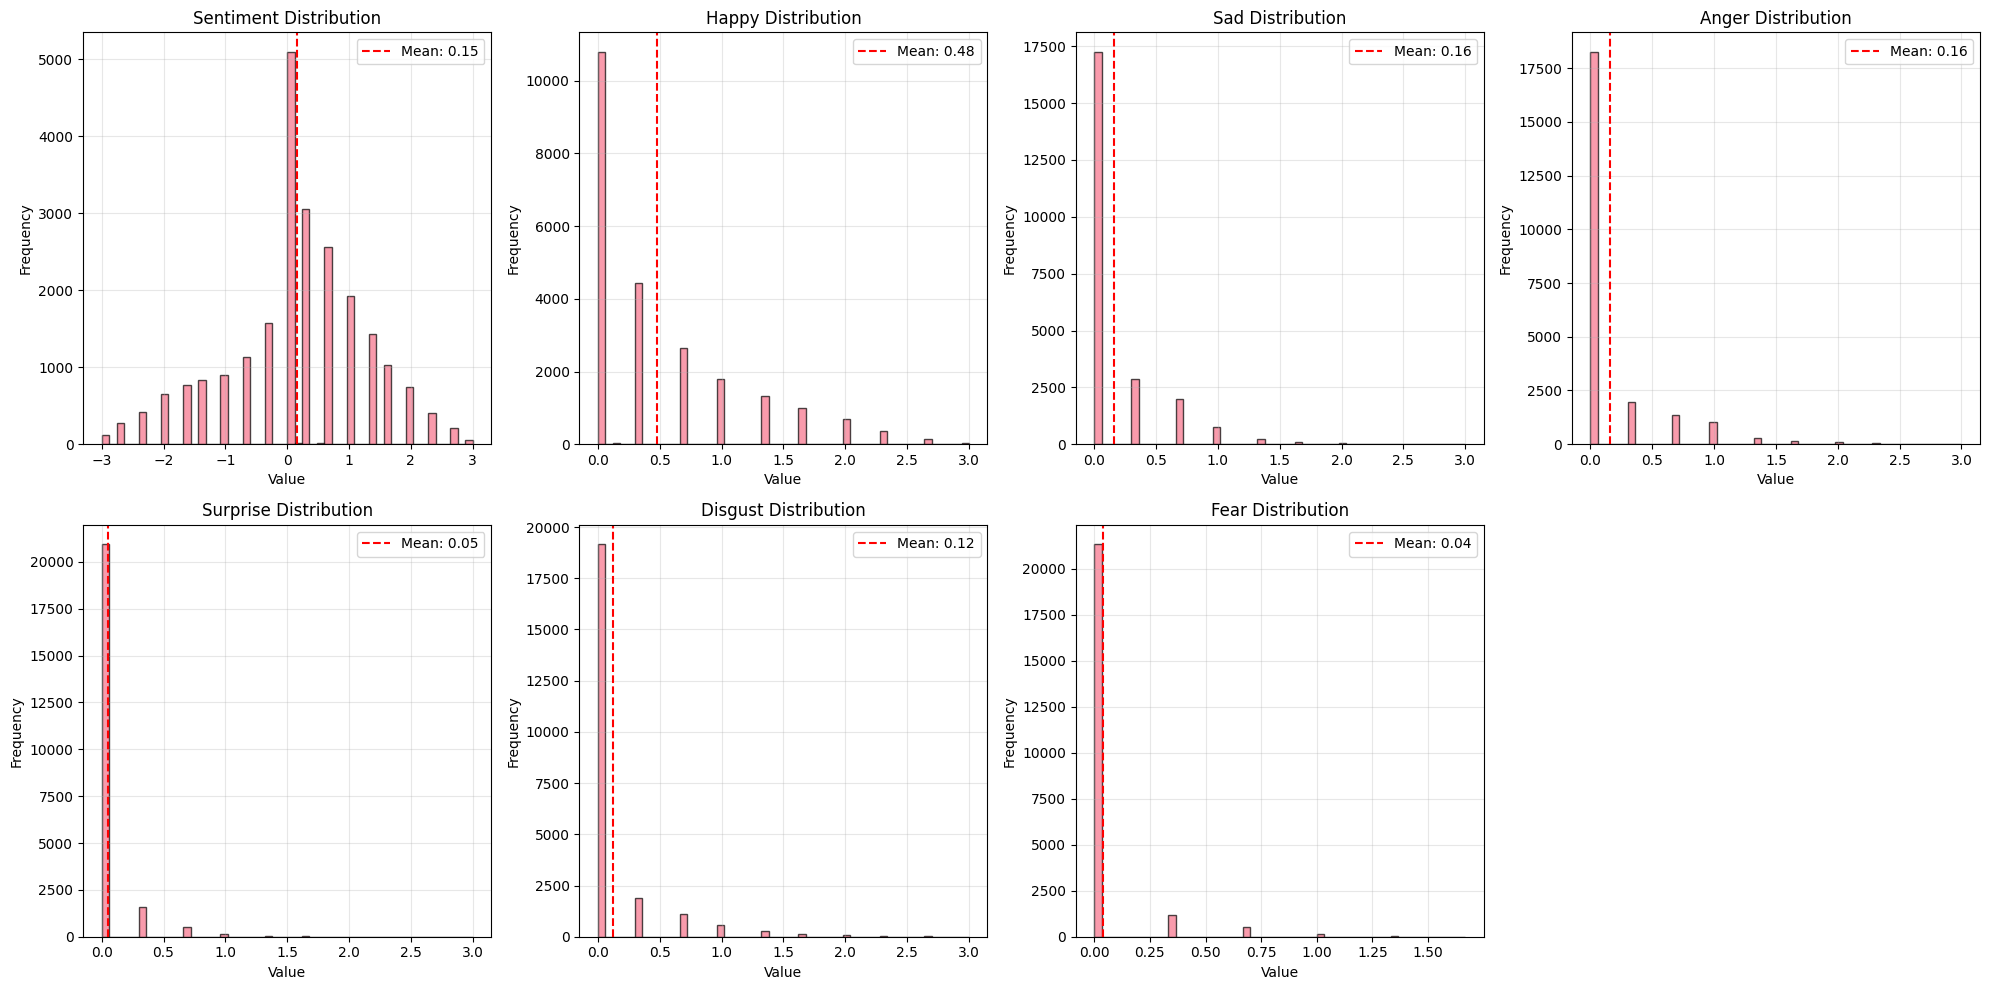

In [ ]:
# Do you want to save the plots?
save_plots = False

# Create figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i in range(n_emotions):
    emotion = emotion_names[i]
    values = all_labels_data[:, i]
    
    # Histogram
    axes[i].hist(values, bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{emotion} Distribution')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics text
    mean_val = values.mean()
    std_val = values.std()
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[i].legend()

# Remove empty subplot
if n_emotions < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
if save_plots:
    plt.savefig('emotion_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
all_labels_data

array([[1.        , 0.6666667 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.6666667 , 0.6666667 , ..., 0.        , 0.        ,
        0.6666667 ],
       [0.6666667 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.6666667 , 0.33333334, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
n_emotions

7

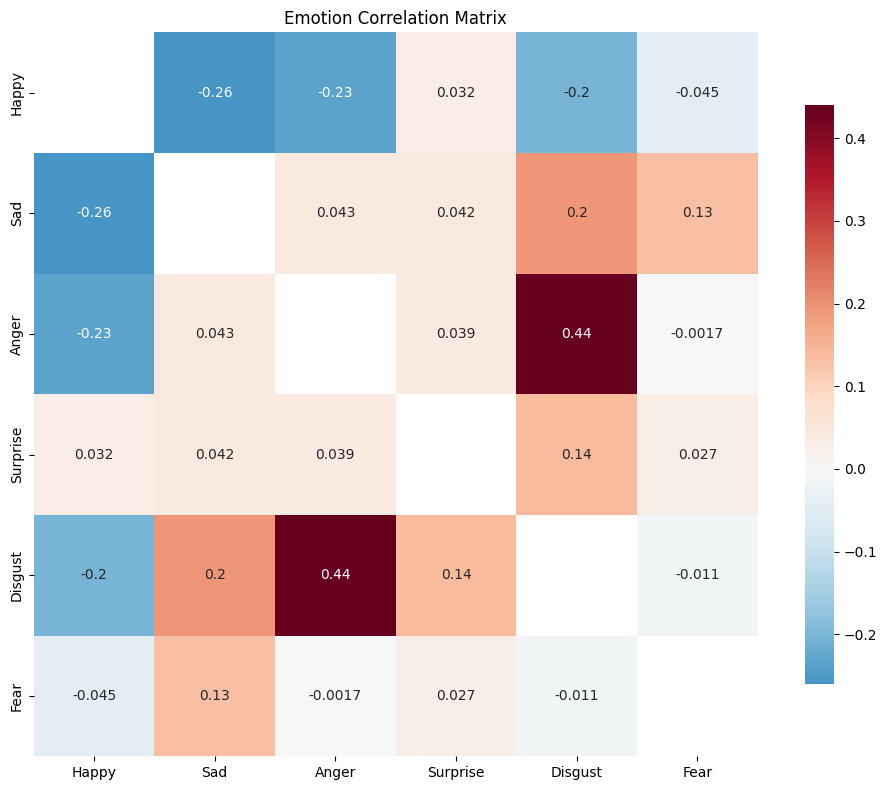

--------------- STRONGEST CORRELATIONS ---------------
Anger - Disgust: 0.441


In [ ]:
# Emotion correlations

emotion_names = ['Sentiment', 'Happy', 'Sad', 'Anger', 'Surprise', 'Disgust', 'Fear'] # From CMU-MOSEI sdk
n_emotions = min(len(emotion_names), all_labels_data.shape[1]) # Because some datasets may not have all emotions

# Calculate correlation matrix (directly and remove the next 3 lines of code)
#corr_matrix = np.corrcoef(all_labels_data[:, :n_emotions].T)

# Ignoring the sentiment now, focusing on emotions only
emotions_only_data = all_labels_data[:, 1:n_emotions]  # Exclude sentiment
n_emotions = n_emotions - 1 # Adjust since we removed sentiment
emotion_names = emotion_names[1:n_emotions+1]  # Adjust names to match

corr_matrix = np.corrcoef(emotions_only_data.T)

# Create correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.eye(corr_matrix.shape[0], dtype=bool)

sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            mask=mask,
            xticklabels=emotion_names[:n_emotions],
            yticklabels=emotion_names[:n_emotions],
            cbar_kws={"shrink": .8})

plt.title('Emotion Correlation Matrix')
plt.tight_layout()
plt.show()

# Print strongest correlations
print("--------------- Strongest Correlations ---------------")
for i in range(n_emotions):
    for j in range(i+1, n_emotions):
        corr_val = corr_matrix[i, j]
        if abs(corr_val) > 0.3:  # Threshold for "strong" correlation
            print(f"{emotion_names[i]} - {emotion_names[j]}: {corr_val:.3f}")


In [ ]:
# Interpreting sentiment labels

sentiment_values = all_labels_data[:, 0]  # First dimension is sentiment
    
print("--------------- Sentiment Interpretation ---------------")
print("Scale: -3 (most negative) to +3 (most positive)")
print()

# Finding examples at different sentiment levels
for target_range, description in [
    ((-3, -2.5), "Very Negative (≤-2.5)"),
    ((-1.5, -0.5), "Moderately Negative"),
    ((-0.5, 0.5), "Neutral"),
    ((0.5, 1.5), "Moderately Positive"),
    ((2.5, 3), "Very Positive (≥2.5)")
]:
    mask = (sentiment_values >= target_range[0]) & (sentiment_values <= target_range[1])
    count = mask.sum()
    percentage = count / len(sentiment_values) * 100
    
    if count > 0:
        example_scores = sentiment_values[mask][:3]  # Show 3 examples
        print(f"{description}: {count} samples ({percentage:.1f}%)")
        print(f"  Example scores: {example_scores}")
        print()

--------------- SENTIMENT INTERPRETATION ---------------
Scale: -3 (most negative) to +3 (most positive)

Very Negative (≤-2.5): 408 samples (1.8%)
  Example scores: [-2.6666667 -2.6666667 -2.6666667]

Moderately Negative: 2873 samples (12.4%)
  Example scores: [-0.6666667 -1.        -1.       ]

Neutral: 9750 samples (41.9%)
  Example scores: [0.         0.         0.33333334]

Moderately Positive: 5945 samples (25.6%)
  Example scores: [1.        1.        0.6666667]

Very Positive (≥2.5): 270 samples (1.2%)
  Example scores: [2.6666667 2.6666667 2.6666667]

